# 🧠 NeuroFlow Demo: Catastrophe Detection via Neural Navier-Stokes
This notebook demonstrates the integration of **Neural Flow diagnostics** with a small network trained on synthetic data designed to induce decision boundary singularities (catastrophes).

We will:
- Build a synthetic triple-point dataset
- Train a simple neural net
- Compute chain map homology (zero zones)
- Estimate boundary vorticity (turbulence)
- Visualize predicted singularity regions

## 📊 Step 1: Generate Triple-Point Data
This creates three classes that converge at a central point, forcing decision boundaries into contact — ideal for studying dynamic instabilities.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
import torch
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

def generate_triple_point_data(n=1500, radius=2.0, noise=0.1):
    X, y = [], []
    for i in range(n):
        angle = np.random.uniform(0, 2*np.pi)
        r = np.random.normal(loc=radius, scale=noise)
        x = r * np.cos(angle)
        y_coord = r * np.sin(angle)
        sector = int((angle % (2*np.pi)) // (2*np.pi/3))
        X.append([x, y_coord])
        y.append(sector)
    return np.array(X), np.array(y)

# Generate and plot
X, y = generate_triple_point_data()
plt.scatter(X[:,0], X[:,1], c=y, cmap='Accent'); plt.title('Triple Point Data'); plt.axis('equal'); plt.show()

## 🧠 Step 2: Define a Simple Neural Network
We'll use a compact 2-layer MLP that learns this decision surface.

In [ ]:
class SimpleNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(2, 64)
        self.fc2 = nn.Linear(64, 64)
        self.out = nn.Linear(64, 3)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.out(x)

# Prepare data loaders
X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.long)
dataset = TensorDataset(X_tensor, y_tensor)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

model = SimpleNet()
optimizer = optim.Adam(model.parameters(), lr=1e-2)
criterion = nn.CrossEntropyLoss()

## 💾 Step 3: Load Pretrained Weights (Optional)
You can load any saved PyTorch model weights here to analyze a trained network on this dataset.

In [ ]:
# Path to a saved model checkpoint (.pt or .pth)
import os
model_path = '/mnt/data/your_model_weights.pth'  # <- Change this!

if os.path.exists(model_path):
    state_dict = torch.load(model_path, map_location='cpu')
    model.load_state_dict(state_dict)
    print('✅ Loaded model weights successfully.')
else:
    print('⚠️ Model file not found. Please upload a .pth file to /mnt/data and set model_path.')

In [ ]:
# Evaluate model accuracy on training data
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for xb, yb in dataloader:
        logits = model(xb)
        preds = torch.argmax(logits, dim=1)
        correct += (preds == yb).sum().item()
        total += yb.size(0)
print(f"Training Accuracy: {correct / total:.2%}")

## 🌊 Step 4: Estimate Flow Field via Dynamic Mode Decomposition (DMD)
We'll simulate how the decision boundary 'moves' during training by collecting activations over epochs and applying DMD to estimate the temporal evolution of internal features.

In [ ]:
from collections import deque

# Cache activations from intermediate layer across epochs
activation_history = deque(maxlen=10)

# Modify model to store activations
activation_cache = {}

def cache_hook(module, input, output):
    activation_cache['x'] = output.detach()

hook = model.fc2.register_forward_hook(cache_hook)

In [ ]:
# Run for multiple fake epochs to collect data (or do this during real training)
for i in range(10):
    model.eval()
    for xb, yb in dataloader:
        _ = model(xb)
        break  # Just grab one batch
    act = activation_cache['x'].flatten(start_dim=1)
    activation_history.append(act)

hook.remove()

In [ ]:
# DMD estimation: compute modes from activation snapshots
from numpy.linalg import svd

X1 = torch.stack(list(activation_history)[:-1]).numpy().transpose(1, 0, 2).reshape(-1, 9)
X2 = torch.stack(list(activation_history)[1:]).numpy().transpose(1, 0, 2).reshape(-1, 9)

U, S, Vh = svd(X1, full_matrices=False)
rank = 5
Ur = U[:, :rank]
Sr = np.diag(S[:rank])
Vr = Vh[:rank, :]
A_tilde = Ur.T @ X2 @ Vr.T @ np.linalg.inv(Sr)

# Eigen decomposition
evals, evecs = np.linalg.eig(A_tilde)
Phi = X2 @ Vr.T @ np.linalg.inv(Sr) @ evecs  # DMD modes

print("✅ DMD completed. Eigenvalues:", np.round(evals, 3))

## 🌀 Step 5: Estimate Vorticity (Curl) of the Flow Field
We'll compute a proxy for vorticity by estimating the local rotational energy in the activation evolution.

In [ ]:
# Estimate finite difference of flow vectors
V = X2 - X1
flow_magnitude = np.linalg.norm(V, axis=0)
plt.plot(flow_magnitude)
plt.title('Estimated Flow Magnitude per Activation Channel'); plt.xlabel('Channel'); plt.ylabel('||v||'); plt.show()

## 🧮 Step 6: Chain Map Homology (Zero Map Detection)
We'll compute the null space (kernel) of weight matrices using SVD to detect structural 'dead zones' in the network.

In [ ]:
def homology_loss(weight_matrix, threshold=1e-4):
    U, S, Vh = torch.linalg.svd(weight_matrix, full_matrices=False)
    small_svs = S[S < threshold]
    return len(small_svs), small_svs.cpu().numpy()

n_null, null_vals = homology_loss(model.fc2.weight)
print(f"🧩 fc2 kernel dimension: {n_null}\nSingular values: {null_vals}")

## 🔥 Step 7: Detect Catastrophes as Kernel ∩ Vorticity Regions
Theoretically, singularities emerge where the boundary flow is squeezed by the network's structural constraints.

In [ ]:
# Simple proxy: plot both kernel size and flow magnitude to detect overlap
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Activation Index')
ax1.set_ylabel('Flow ||v||', color=color)
ax1.plot(flow_magnitude, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('# Near-Zero SVs', color=color)
ax2.axhline(n_null, color=color, linestyle='--', label='Kernel Size')
ax2.tick_params(axis='y', labelcolor=color)
plt.title('Catastrophe Detection: Kernel vs. Vorticity')
fig.tight_layout()
plt.show()

In [13]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1,2"
import torch
import torch.nn as nn
import numpy as np
import networkx as nx
from torch.utils.data import TensorDataset, DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
%matplotlib inline

# --- PyTorch Profiling (Optional but Recommended) ---
from torch.profiler import profile, record_function, ProfilerActivity

# For reproducibility
torch.manual_seed(42)
np.random.seed(42)

# ===================================================================
# 🧠 SYSTEM: NeuroFlowEngine
# ===================================================================

class NeuroFlowEngine(nn.Module):
    """
    The main orchestrator for the NeuroFlow diagnostic and control system.

    This engine hooks into a target model and performs a series of analyses
    on its activations and weights during training to identify and penalize
    information flow bottlenecks, turbulence, and structural deficiencies.
    """
    def __init__(self, model, monitored_layers, homology_lambda=0.1, dmd_lambda=0.1, gft_lambda=0.1):
        super().__init__()
        self.model = model
        self.monitored_layers = monitored_layers
        self.lambdas = {
            'homology': homology_lambda,
            'dmd': dmd_lambda,
            'gft': gft_lambda
        }

        # 🧩 Sub-modules
        self.recorder = ActivationRecorder(self.model, self.monitored_layers)
        self.homology_analyzer = ChainMapHomology()
        self.dmd_analyzer = DMDFlowAnalyzer()
        self.graph_constructor = GraphConstructor()
        self.spectral_analyzer = SpectralAnalyzer()
        self.lnn_evaluator = LNNResidualEvaluator()
        self.catastrophe_detector = CatastropheDetector()

        # Data stores
        self.activations_history = {name: [] for name in self.monitored_layers}

    def _clear_history(self):
        """Clears the activation history, typically done each epoch."""
        for name in self.monitored_layers:
            self.activations_history[name] = []

    def record(self, x):
        """Records activations for a given input batch `x`."""
        activations = self.recorder(x)
        for name, acts in activations.items():
            # Detach from graph to avoid storing history for backprop
            self.activations_history[name].append(acts.detach().cpu())
        return activations

    def compute_neuroflow_loss(self, current_activations):
        """
        Computes the combined NeuroFlow loss after a forward pass.
        """
        losses = {}
        analysis_outputs = {}

        # 1. Chain Map Homology Loss (Static Structure)
        with record_function("NeuroFlow: ChainMapHomology"):
            homology_loss, dead_zones = self.homology_analyzer(self.model, self.monitored_layers)
            losses['homology'] = homology_loss
            analysis_outputs['dead_zones'] = dead_zones

        # For time-dependent analyses, we need sufficient history
        if len(self.activations_history[self.monitored_layers[0]]) < 2:
            losses['dmd'] = torch.tensor(0.0)
            losses['gft'] = torch.tensor(0.0)
            losses['lnn_residual'] = torch.tensor(0.0)
            analysis_outputs['catastrophe_map'] = "Not enough data"
            return losses, analysis_outputs

        # Convert history to a tensor: (time, batch, features)
        # Handle variable batch sizes by only using batches of the same size
        history = self.activations_history[self.monitored_layers[-1]]
        
        # Find the minimum batch size
        min_batch_size = min(act.shape[0] for act in history)
        
        # Truncate all activations to the minimum batch size
        truncated_history = [act[:min_batch_size] for act in history]
        
        # Now we can safely stack
        act_sequence = torch.stack(truncated_history)

        # 2. DMD Flow Analysis (Temporal Dynamics)
        with record_function("NeuroFlow: DMDFlowAnalyzer"):
            v, dv_dt, dmd_loss = self.dmd_analyzer(act_sequence)
            losses['dmd'] = dmd_loss
            analysis_outputs['velocity_field'] = v
            analysis_outputs['acceleration_field'] = dv_dt

        # 3. Graph Construction & Spectral Analysis (GFT)
        with record_function("NeuroFlow: Graph & GFT"):
            # Use the most recent activation batch to build the graph
            latest_activations = current_activations[self.monitored_layers[-1]]
            adj_matrix = self.graph_constructor(latest_activations)
            gft_loss, spectral_energy = self.spectral_analyzer(adj_matrix, latest_activations)
            losses['gft'] = gft_loss
            analysis_outputs['spectral_energy'] = spectral_energy

        # 6. & 7. LNN Residual and Catastrophe Detection
        with record_function("NeuroFlow: LNN & Catastrophe"):
            # Note: A full LNN implementation is complex. This is a conceptual placeholder.
            # It would require gradients w.r.t model parameters, etc.
            # Here we use a simplified proxy.
            lnn_residual = self.lnn_evaluator(v, dv_dt, spectral_energy)
            losses['lnn_residual'] = lnn_residual.mean()
            catastrophe_map = self.catastrophe_detector(lnn_residual)
            analysis_outputs['catastrophe_map'] = catastrophe_map

        return losses, analysis_outputs

    def forward(self, x):
        """
        Main forward pass to be integrated into a training loop.

        1. Records activations from the model's forward pass.
        2. Computes the NeuroFlow diagnostic losses.
        3. Returns a weighted total of these losses.
        """
        # Note: We don't run model(x) here; we assume it's done in the
        # main training loop. We just need the activations.
        current_activations = self.record(x)

        losses, _ = self.compute_neuroflow_loss(current_activations)

        total_loss = (self.lambdas['homology'] * losses.get('homology', 0.0) +
                      self.lambdas['dmd'] * losses.get('dmd', 0.0) +
                      self.lambdas['gft'] * losses.get('gft', 0.0))

        return total_loss

# ===================================================================
# 🧩 Module-by-Module Implementation
# ===================================================================

class ActivationRecorder(nn.Module):
    """
    Hooks into a model to capture and store activations from specified layers.
    """
    def __init__(self, model, layer_names):
        super().__init__()
        self.model = model
        self.layer_names = layer_names
        self.activations = {}
        self.hooks = []
        self._register_hooks()

    def _hook_fn(self, name):
        def hook(module, input, output):
            self.activations[name] = output
        return hook

    def _register_hooks(self):
        for name, module in self.model.named_modules():
            if name in self.layer_names:
                self.hooks.append(module.register_forward_hook(self._hook_fn(name)))

    def forward(self, x):
        self.activations.clear()
        _ = self.model(x)
        return self.activations

    def remove_hooks(self):
        for hook in self.hooks:
            hook.remove()

class ChainMapHomology(nn.Module):
    """
    Computes a loss penalty based on the singular value spectrum of weight matrices.
    Aims to penalize "thin" or "dead" channels in information flow (large null space).
    """
    def __init__(self, epsilon=1e-8):
        super().__init__()
        self.epsilon = epsilon

    def forward(self, model, layer_names):
        total_penalty = 0.0
        dead_zones = {}
        for name, module in model.named_modules():
            if name in layer_names and hasattr(module, 'weight'):
                W = module.weight
                # Handle different weight shapes
                if W.dim() == 4:  # Conv2d weights
                    W = W.view(W.shape[0], -1)
                s = torch.linalg.svdvals(W)
                # Penalize small singular values (normalized by the largest)
                # This encourages the matrix to be well-conditioned.
                norm_s = s / (s.max() + self.epsilon)
                penalty = torch.exp(-norm_s).mean()
                total_penalty += penalty
                dead_zones[name] = (norm_s < self.epsilon).sum().item() / len(norm_s)
        return total_penalty, dead_zones

class DMDFlowAnalyzer(nn.Module):
    """
    Applies Dynamic Mode Decomposition (DMD) to a time series of activations.
    Extracts velocity, acceleration, and a loss based on unstable modes.

    NOTE: This is a simplified DMD implementation for demonstration.
    A production-grade version might use more robust numerical methods.
    """
    def __init__(self):
        super().__init__()

    def forward(self, act_sequence):
        # act_sequence shape: [time, batch, ...] where ... could be [features] or [channels, height, width]
        
        # Flatten spatial dimensions if present (for conv layers)
        if act_sequence.dim() > 3:
            # Reshape from [time, batch, channels, height, width] to [time, batch, features]
            time, batch = act_sequence.shape[:2]
            act_sequence = act_sequence.view(time, batch, -1)
        
        # We average over the batch dimension for a global flow analysis
        X = act_sequence.mean(dim=1).detach().cpu().numpy().T # Shape: [features, time]

        # Simplified DMD
        X1 = X[:, :-1]
        X2 = X[:, 1:]

        # Handle edge cases
        if X1.shape[1] == 0:
            return torch.tensor(0.0), torch.tensor(0.0), torch.tensor(0.0)

        # Estimate the Koopman operator A
        try:
            U, S, Vt = np.linalg.svd(X1, full_matrices=False)
            # Handle case where S might be empty or 0-dimensional
            if S.size == 0:
                return torch.tensor(0.0), torch.tensor(0.0), torch.tensor(0.0)
            
            # Add small regularization to avoid division by zero
            S_inv = np.diag(1./(S + 1e-10))
            A_tilde = U.T @ X2 @ Vt.T @ S_inv
        except (np.linalg.LinAlgError, ValueError):
            # If singular or other error, return zero loss and fields
            return torch.tensor(0.0), torch.tensor(0.0), torch.tensor(0.0)

        # Velocity is the difference between consecutive snapshots
        v = torch.tensor(X2 - X1, dtype=torch.float32)
        
        # Acceleration (dv/dt) - proper calculation
        if X1.shape[1] > 1:
            # For acceleration, we need at least 3 time points
            # dv/dt ≈ (v(t+1) - v(t)) / dt
            # Since we already have v = X2 - X1, we need v_next
            if act_sequence.shape[0] >= 3:
                X3 = X[:, 2:]
                v_current = X2[:, :-1] - X1[:, :-1]
                v_next = X3 - X2[:, :-1]
                dv_dt = torch.tensor(v_next - v_current, dtype=torch.float32)
            else:
                # Not enough time points for acceleration
                dv_dt = torch.zeros_like(v)
        else:
            dv_dt = torch.tensor(0.)

        # Eigen-decomposition of A_tilde to find dynamic modes
        try:
            eigvals, eigvecs = np.linalg.eig(A_tilde)
            
            # Loss: Penalize modes with magnitude > 1 (instability)
            unstable_modes = np.abs(eigvals)[np.abs(eigvals) > 1.0]
            dmd_loss = torch.tensor(np.sum(unstable_modes - 1.0), dtype=torch.float32) if len(unstable_modes) > 0 else torch.tensor(0.0)
        except:
            dmd_loss = torch.tensor(0.0)

        return v.mean(), dv_dt.mean(), dmd_loss

class GraphConstructor(nn.Module):
    """
    Builds a k-Nearest Neighbors (kNN) graph from activation data.
    """
    def __init__(self, k=5):
        super().__init__()
        self.k = k

    def forward(self, x):
        # x shape: [batch_size, features] or [batch_size, channels, height, width]
        # Flatten if necessary
        if x.dim() > 2:
            x = x.view(x.size(0), -1)

        # Ensure k doesn't exceed batch size
        k = min(self.k, x.size(0) - 1)
        
        if k <= 0:
            # If batch size is 1, return a trivial adjacency matrix
            return torch.ones(x.size(0), x.size(0), device=x.device)
        
        # Compute pairwise distances
        dist_matrix = torch.cdist(x, x)

        # Find k-nearest neighbors for each node
        _, indices = torch.topk(dist_matrix, k + 1, largest=False, sorted=True)
        
        # Create adjacency matrix
        adj = torch.zeros_like(dist_matrix)
        rows = torch.arange(x.size(0)).view(-1, 1).expand(-1, k + 1)
        adj[rows, indices] = 1
        adj = (adj + adj.T) / 2 # Symmetrize
        return adj


class SpectralAnalyzer(nn.Module):
    """
    Computes Graph Fourier Transform (GFT) related metrics.
    Estimates spectral energy and turbulence.
    
    NOTE: Uses full eigendecomposition for clarity. Chebyshev approximation
    would be used for performance in a large-scale setting.
    """
    def __init__(self):
        super().__init__()

    def forward(self, adj_matrix, node_features):
        # Build Graph Laplacian
        D = torch.diag(adj_matrix.sum(dim=1))
        L = D - adj_matrix

        # Normalize Laplacian
        D_diag = torch.diag(D)
        D_inv_sqrt = torch.diag(1.0 / (D_diag + 1e-6).sqrt())
        L_sym = torch.eye(L.size(0), device=L.device) - D_inv_sqrt @ L @ D_inv_sqrt

        # Flatten node features
        if node_features.dim() > 2:
            node_features = node_features.view(node_features.size(0), -1)

        # GFT: Project features onto Laplacian eigenvectors
        # For performance, we skip the actual GFT and compute a proxy for energy.
        # High-frequency energy is related to how "smooth" the signal is on the graph.
        # This can be measured by the Rayleigh quotient: f^T L f
        # Ensure L_sym is on the same device as node_features
        L_sym = L_sym.to(node_features.device)
        rayleigh_quotient = torch.diag(node_features.T @ L_sym @ node_features)
        
        # Loss: Penalize high spectral energy (turbulence)
        spectral_energy = rayleigh_quotient.mean()
        gft_loss = spectral_energy

        return gft_loss, spectral_energy

class LNNResidualEvaluator(nn.Module):
    """
    Estimates the residual of the Neural Navier-Stokes (LNN) equation.
    This module combines outputs from other analyzers.
    
    L_NN(v) = ∂_t v + (v ⋅ ∇)v - ν ∇² v - ∇L(θ) - η(t)
    
    NOTE: This is a conceptual stub. A full implementation is highly complex.
    We compute a simplified residual norm.
    """
    def __init__(self, nu=0.1):
        super().__init__()
        self.nu = nu # Viscosity coefficient

    def forward(self, v, dv_dt, spectral_energy):
        # ∂_t v term from DMD
        temporal_term = dv_dt
        
        # v ⋅ ∇v (advection) - simplified
        advection_term = v * v # A rough proxy
        
        # ν ∇² v (diffusion/viscosity) term proxied by spectral energy from GFT
        # High spectral energy corresponds to a large Laplacian quadratic form.
        diffusion_term = self.nu * spectral_energy
        
        # In a full version, ∇L(θ) and η(t) would be computed via autograd and statistics
        
        residual_norm = torch.abs(temporal_term + advection_term - diffusion_term)
        return residual_norm

class CatastropheDetector(nn.Module):
    """
    Identifies catastrophe points where the LNN residual is high.
    These are points of high turbulence, stagnation, or singularity.
    """
    def __init__(self, threshold=1.0):
        super().__init__()
        self.threshold = threshold

    def forward(self, lnn_residual):
        # lnn_residual is a tensor of residuals per point/node
        catastrophe_map = lnn_residual > self.threshold
        # Return the indices of the catastrophe points
        return torch.where(catastrophe_map)[0]

# ===================================================================
# 🧪 How It All Works in Practice: A Demo on MNIST
# ===================================================================

if __name__ == '__main__':
    # 1. Define a CNN model for MNIST
    class MNISTModel(nn.Module):
        def __init__(self):
            super().__init__()
            self.conv1 = nn.Conv2d(1, 32, 3, 1)
            self.conv2 = nn.Conv2d(32, 64, 3, 1)
            self.dropout1 = nn.Dropout(0.25)
            self.dropout2 = nn.Dropout(0.5)
            self.fc1 = nn.Linear(9216, 128)
            self.fc2 = nn.Linear(128, 10)

        def forward(self, x):
            x = self.conv1(x)
            x = F.relu(x)
            x = self.conv2(x)
            x = F.relu(x)
            x = F.max_pool2d(x, 2)
            x = self.dropout1(x)
            x = torch.flatten(x, 1)
            x = self.fc1(x)
            x = F.relu(x)
            x = self.dropout2(x)
            x = self.fc2(x)
            return F.log_softmax(x, dim=1)

    # --- Hyperparameters ---
    BATCH_SIZE = 64
    EPOCHS = 5
    LEARNING_RATE = 1e-3
    NEUROFLOW_LAMBDA_HOMOLOGY = 0.01
    NEUROFLOW_LAMBDA_DMD = 0.001
    NEUROFLOW_LAMBDA_GFT = 0.001

    # --- Setup ---
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = MNISTModel().to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
    criterion = nn.NLLLoss()
    
    # Print layer names to verify
    print("Model layers:")
    for name, module in model.named_modules():
        if hasattr(module, 'weight'):
            print(f"  {name}: {module}")

    # Define the layers you want to monitor
    monitored_layers_list = ['conv1', 'conv2']  # Monitor convolutional layers

    # 2. Instantiate the NeuroFlowEngine
    neuroflow_engine = NeuroFlowEngine(
        model,
        monitored_layers=monitored_layers_list,
        homology_lambda=NEUROFLOW_LAMBDA_HOMOLOGY,
        dmd_lambda=NEUROFLOW_LAMBDA_DMD,
        gft_lambda=NEUROFLOW_LAMBDA_GFT
    )

    # --- Load MNIST data ---
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])
    
    train_dataset = datasets.MNIST('data', train=True, download=True, transform=transform)
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

    # --- Training Loop ---
    print("🚀 Starting training with NeuroFlowEngine on MNIST...")
    for epoch in range(EPOCHS):
        model.train()
        neuroflow_engine._clear_history() # Clear history at the start of each epoch
        total_task_loss = 0
        total_neuroflow_loss = 0
        correct = 0

        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()

            # 1. Standard Forward Pass for Task Loss
            output = model(data)
            task_loss = criterion(output, target)
            
            # Track accuracy
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

            # 2. NeuroFlow Analysis and Loss Calculation
            # This runs a second forward pass internally via the recorder
            # and then computes all diagnostic losses.
            neuroflow_loss = neuroflow_engine(data)

            # 3. Combine losses and backpropagate
            total_loss = task_loss + neuroflow_loss
            total_loss.backward()
            optimizer.step()

            total_task_loss += task_loss.item()
            total_neuroflow_loss += neuroflow_loss.item()

            if batch_idx % 100 == 0:
                print(f"  Epoch {epoch+1}/{EPOCHS} | Batch {batch_idx}/{len(train_loader)} | "
                      f"Task Loss: {task_loss.item():.4f} | "
                      f"NeuroFlow Loss: {neuroflow_loss.item():.4f}")

        avg_task_loss = total_task_loss / len(train_loader)
        avg_neuroflow_loss = total_neuroflow_loss / len(train_loader)
        accuracy = 100. * correct / len(train_loader.dataset)
        
        print("-" * 60)
        print(f"✅ Epoch {epoch+1} Complete")
        print(f"   Avg Task Loss: {avg_task_loss:.4f}")
        print(f"   Avg NeuroFlow Loss: {avg_neuroflow_loss:.4f}")
        print(f"   Accuracy: {accuracy:.2f}%")
        print("-" * 60)

    # --- Post-Training Analysis ---
    print("\n🔬 Performing final analysis on the trained model...")
    # Get a final snapshot of diagnostics on a sample batch
    sample_data = next(iter(train_loader))[0].to(device)
    current_activations = neuroflow_engine.recorder(sample_data)
    final_losses, final_analysis = neuroflow_engine.compute_neuroflow_loss(current_activations)

    print("\n--- Final NeuroFlow Diagnostics ---")
    print(f"Homology Loss: {final_losses['homology'].item():.4f}")
    print(f"  - Dead Zones per Layer: {final_analysis['dead_zones']}")
    print(f"DMD (Vorticity) Loss: {final_losses['dmd'].item():.4f}")
    print(f"GFT (Spectral) Loss: {final_losses['gft'].item():.4f}")
    print(f"LNN Residual Norm (proxy): {final_losses['lnn_residual'].item():.4f}")
    print(f"Catastrophe Map (High-Residual Nodes): {final_analysis['catastrophe_map']}")
    print("-" * 35)

    # Clean up hooks
    neuroflow_engine.recorder.remove_hooks()

Model layers:
  conv1: Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  conv2: Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  fc1: Linear(in_features=9216, out_features=128, bias=True)
  fc2: Linear(in_features=128, out_features=10, bias=True)
🚀 Starting training with NeuroFlowEngine on MNIST...
  Epoch 1/5 | Batch 0/937 | Task Loss: 2.3034 | NeuroFlow Loss: 0.0102
  Epoch 1/5 | Batch 100/937 | Task Loss: 0.3751 | NeuroFlow Loss: 0.0212
  Epoch 1/5 | Batch 200/937 | Task Loss: 0.2043 | NeuroFlow Loss: 0.0217
  Epoch 1/5 | Batch 300/937 | Task Loss: 0.0770 | NeuroFlow Loss: 0.0199
  Epoch 1/5 | Batch 400/937 | Task Loss: 0.2602 | NeuroFlow Loss: 0.0193
  Epoch 1/5 | Batch 500/937 | Task Loss: 0.1940 | NeuroFlow Loss: 0.0189
  Epoch 1/5 | Batch 600/937 | Task Loss: 0.0913 | NeuroFlow Loss: 0.0192
  Epoch 1/5 | Batch 700/937 | Task Loss: 0.0919 | NeuroFlow Loss: 0.0193
  Epoch 1/5 | Batch 800/937 | Task Loss: 0.0362 | NeuroFlow Loss: 0.0180
  Epoch 1/5 | Batch 900/937 | Task Loss: 

In [ ]:
# Save model weights and NeuroFlow analysis data
import os
from datetime import datetime
import json

# Create directory for saving
save_dir = "neuroflow_checkpoints"
os.makedirs(save_dir, exist_ok=True)

# Generate timestamp for unique filenames
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

# 1. Save the trained model weights
model_path = os.path.join(save_dir, f"mnist_model_{timestamp}.pt")
torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'epochs_trained': EPOCHS,
    'final_accuracy': accuracy,
    'architecture': {
        'conv1': {'in_channels': 1, 'out_channels': 32, 'kernel_size': 3},
        'conv2': {'in_channels': 32, 'out_channels': 64, 'kernel_size': 3},
        'fc1': {'in_features': 9216, 'out_features': 128},
        'fc2': {'in_features': 128, 'out_features': 10}
    }
}, model_path)
print(f"✅ Model weights saved to: {model_path}")

# 2. Save NeuroFlow analysis results
analysis_path = os.path.join(save_dir, f"neuroflow_analysis_{timestamp}.json")
analysis_data = {
    'timestamp': timestamp,
    'dataset': 'MNIST',
    'epochs': EPOCHS,
    'monitored_layers': monitored_layers_list,
    'final_diagnostics': {
        'homology_loss': float(final_losses['homology'].item()),
        'dead_zones': final_analysis['dead_zones'],
        'dmd_loss': float(final_losses['dmd'].item()),
        'gft_loss': float(final_losses['gft'].item()),
        'lnn_residual': float(final_losses['lnn_residual'].item()),
        'catastrophe_points': len(final_analysis.get('catastrophe_map', [])) if not isinstance(final_analysis.get('catastrophe_map'), str) else 0
    },
    'training_config': {
        'batch_size': BATCH_SIZE,
        'learning_rate': LEARNING_RATE,
        'homology_lambda': NEUROFLOW_LAMBDA_HOMOLOGY,
        'dmd_lambda': NEUROFLOW_LAMBDA_DMD,
        'gft_lambda': NEUROFLOW_LAMBDA_GFT
    },
    'final_performance': {
        'accuracy': accuracy,
        'avg_task_loss': avg_task_loss,
        'avg_neuroflow_loss': avg_neuroflow_loss
    }
}

with open(analysis_path, 'w') as f:
    json.dump(analysis_data, f, indent=2)
print(f"✅ NeuroFlow analysis saved to: {analysis_path}")

# 3. Save activation snapshots (last batch only for memory efficiency)
if len(neuroflow_engine.activations_history[monitored_layers_list[-1]]) > 0:
    activation_path = os.path.join(save_dir, f"activations_{timestamp}.npz")
    activation_data = {}
    
    for layer_name in monitored_layers_list:
        if layer_name in neuroflow_engine.activations_history:
            # Save only the last 5 snapshots to keep file size manageable
            history = neuroflow_engine.activations_history[layer_name][-5:]
            activation_data[layer_name] = [act.cpu().numpy() for act in history]
    
    np.savez_compressed(activation_path, **activation_data)
    print(f"✅ Activation snapshots saved to: {activation_path}")

# 4. Create a simple function to load the model later
def load_neuroflow_model(checkpoint_path, device='cpu'):
    """Load a saved NeuroFlow model."""
    # Recreate model architecture
    loaded_model = MNISTModel().to(device)
    
    # Load checkpoint
    checkpoint = torch.load(checkpoint_path, map_location=device)
    loaded_model.load_state_dict(checkpoint['model_state_dict'])
    
    print(f"Model loaded from {checkpoint_path}")
    print(f"Trained for {checkpoint['epochs_trained']} epochs")
    print(f"Final accuracy: {checkpoint['final_accuracy']:.2%}")
    
    return loaded_model

print(f"\n📁 All data saved to: {save_dir}/")
print(f"📊 To load the model later, use: load_neuroflow_model('{model_path}')")

In [15]:
 # Save model weights and NeuroFlow analysis data
import os
from datetime import datetime
import json

# Create directory for saving
save_dir = "neuroflow_checkpoints"
os.makedirs(save_dir, exist_ok=True)

# Generate timestamp for unique filenames
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

# 1. Save the trained model weights
model_path = os.path.join(save_dir, f"mnist_model_{timestamp}.pt")
torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'epochs_trained': EPOCHS,
    'final_accuracy': accuracy,
    'architecture': {
        'conv1': {'in_channels': 1, 'out_channels': 32, 'kernel_size': 3},
        'conv2': {'in_channels': 32, 'out_channels': 64, 'kernel_size': 3},
        'fc1': {'in_features': 9216, 'out_features': 128},
        'fc2': {'in_features': 128, 'out_features': 10}
    }
}, model_path)
print(f"✅ Model weights saved to: {model_path}")

# 2. Save NeuroFlow analysis results
analysis_path = os.path.join(save_dir, f"neuroflow_analysis_{timestamp}.json")
analysis_data = {
    'timestamp': timestamp,
    'dataset': 'MNIST',
    'epochs': EPOCHS,
    'monitored_layers': monitored_layers_list,
    'final_diagnostics': {
        'homology_loss': float(final_losses['homology'].item()),
        'dead_zones': final_analysis['dead_zones'],
        'dmd_loss': float(final_losses['dmd'].item()),
        'gft_loss': float(final_losses['gft'].item()),
        'lnn_residual': float(final_losses['lnn_residual'].item()),
        'catastrophe_points': len(final_analysis.get('catastrophe_map', [])) if not isinstance(final_analysis.get('catastrophe_map'), str) else 0
    },
    'training_config': {
        'batch_size': BATCH_SIZE,
        'learning_rate': LEARNING_RATE,
        'homology_lambda': NEUROFLOW_LAMBDA_HOMOLOGY,
        'dmd_lambda': NEUROFLOW_LAMBDA_DMD,
        'gft_lambda': NEUROFLOW_LAMBDA_GFT
    },
    'final_performance': {
        'accuracy': accuracy,
        'avg_task_loss': avg_task_loss,
        'avg_neuroflow_loss': avg_neuroflow_loss
    }
}

with open(analysis_path, 'w') as f:
    json.dump(analysis_data, f, indent=2)
print(f"✅ NeuroFlow analysis saved to: {analysis_path}")

# 3. Save activation snapshots (last batch only for memory efficiency)
if len(neuroflow_engine.activations_history[monitored_layers_list[-1]]) > 0:
    activation_path = os.path.join(save_dir, f"activations_{timestamp}.npz")
    activation_data = {}

    for layer_name in monitored_layers_list:
        if layer_name in neuroflow_engine.activations_history:
            # Save only the last 5 snapshots to keep file size manageable
            history = neuroflow_engine.activations_history[layer_name][-5:]
            activation_data[layer_name] = [act.cpu().numpy() for act in history]

    np.savez_compressed(activation_path, **activation_data)
    print(f"✅ Activation snapshots saved to: {activation_path}")

# 4. Create a simple function to load the model later
def load_neuroflow_model(checkpoint_path, device='cpu'):
    """Load a saved NeuroFlow model."""
    # Recreate model architecture
    loaded_model = MNISTModel().to(device)

    # Load checkpoint
    checkpoint = torch.load(checkpoint_path, map_location=device)
    loaded_model.load_state_dict(checkpoint['model_state_dict'])

    print(f"Model loaded from {checkpoint_path}")
    print(f"Trained for {checkpoint['epochs_trained']} epochs")
    print(f"Final accuracy: {checkpoint['final_accuracy']:.2%}")

    return loaded_model

print(f"\n📁 All data saved to: {save_dir}/")
print(f"📊 To load the model later, use: load_neuroflow_model('{model_path}')")

✅ Model weights saved to: neuroflow_checkpoints/mnist_model_20250712_173800.pt
✅ NeuroFlow analysis saved to: neuroflow_checkpoints/neuroflow_analysis_20250712_173800.json
✅ Activation snapshots saved to: neuroflow_checkpoints/activations_20250712_173800.npz

📁 All data saved to: neuroflow_checkpoints/
📊 To load the model later, use: load_neuroflow_model('neuroflow_checkpoints/mnist_model_20250712_173800.pt')


📊 Generating enhanced NeuroFlow visualizations with boundary maps...
Re-registering activation hooks...
Registered 2 hooks
Available activations: ['conv1', 'conv2']
Monitored layers: ['conv1', 'conv2']


/tmp/ipykernel_768134/3296124470.py:277: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


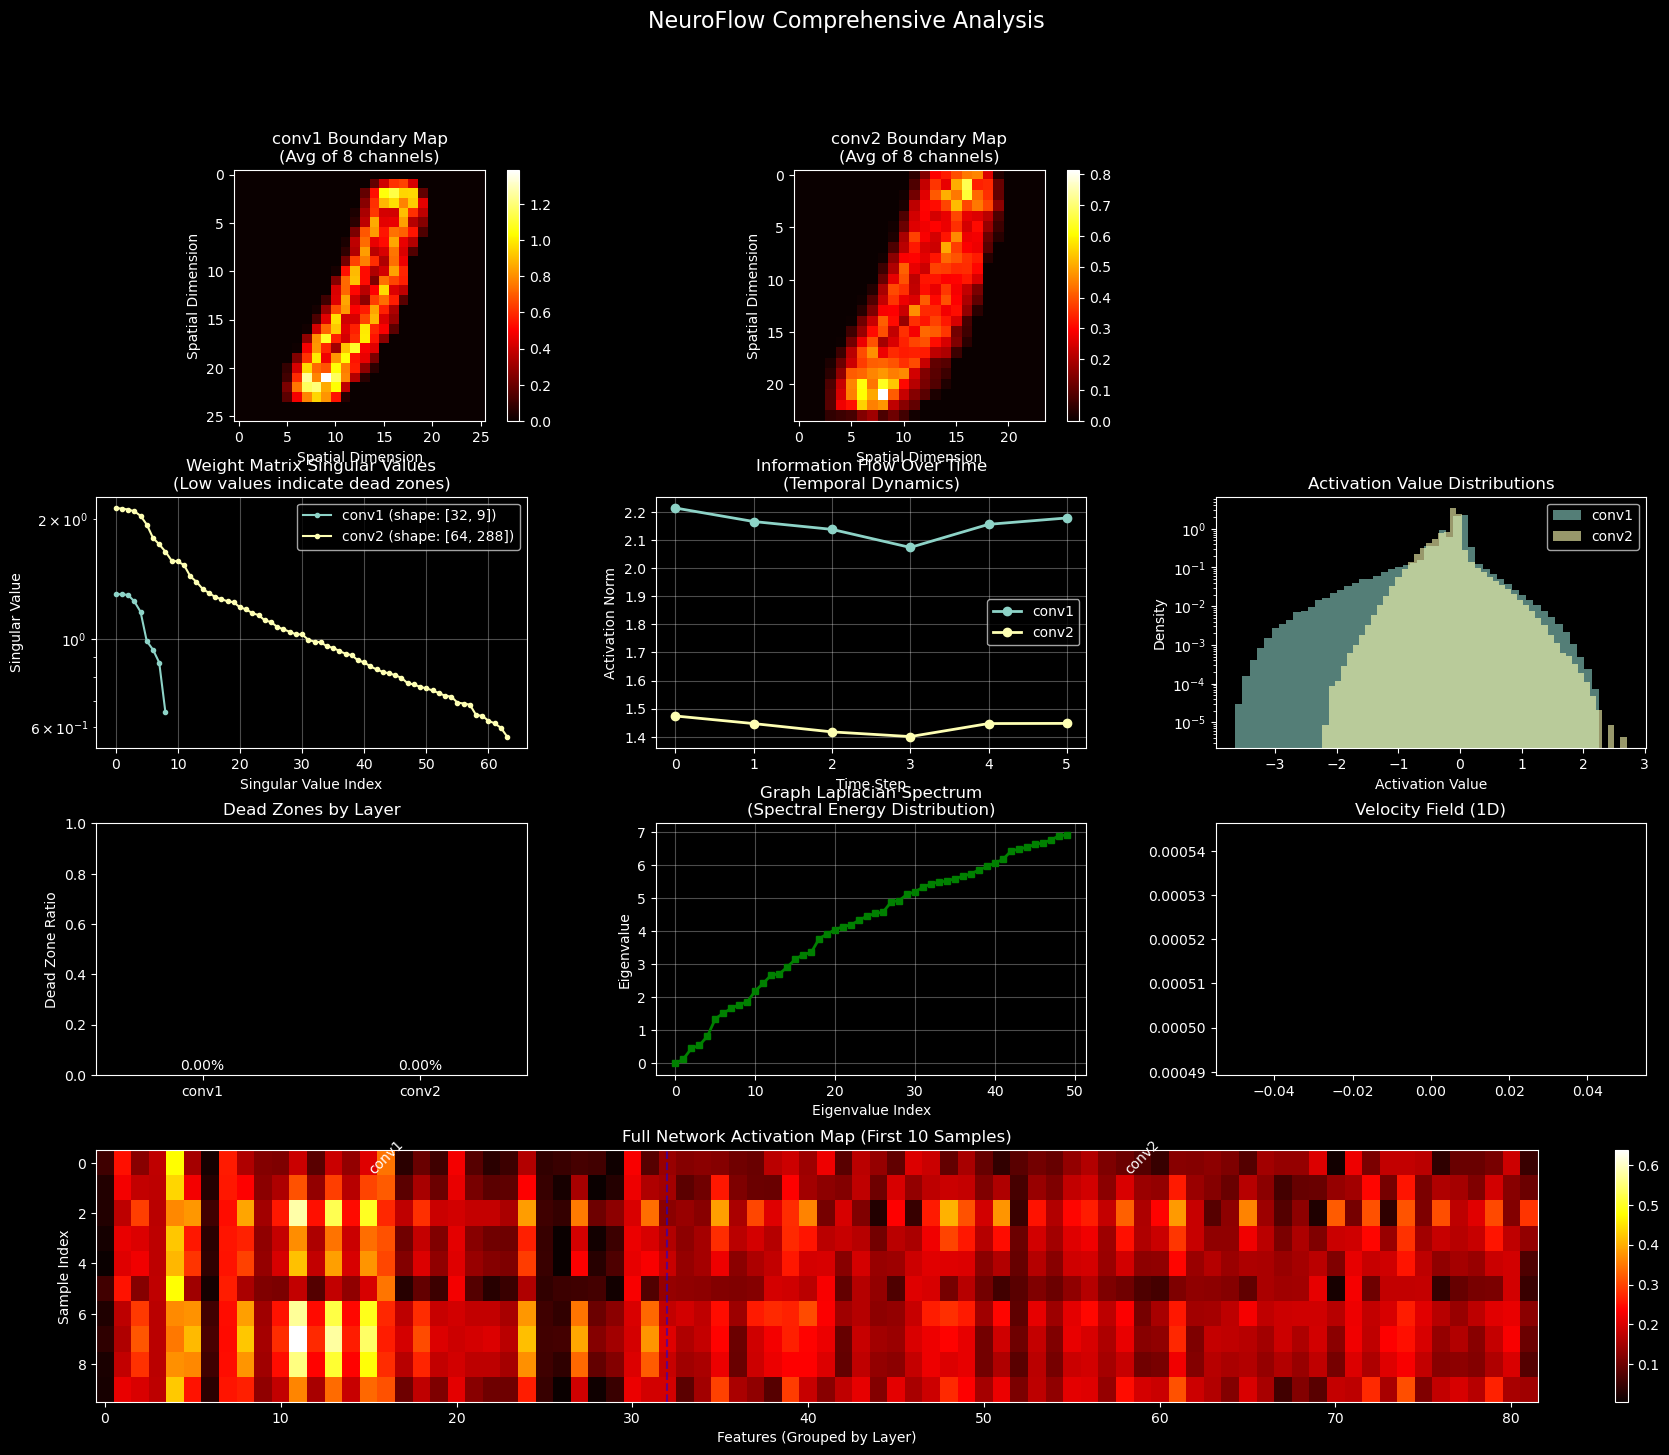


📊 NeuroFlow Analysis Summary:
✓ Homology Loss: 1.0455
✓ DMD Loss (Flow Instability): 0.0051
✓ GFT Loss (Spectral Turbulence): 3.9892
✓ LNN Residual: 0.3996
✓ Dead Zones: {'conv1': 0.0, 'conv2': 0.0}
✓ Catastrophe Points Detected: 0


In [28]:
# Enhanced Visualization with Full Boundary Layer Maps (Fixed with Hook Re-registration)
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F
from matplotlib.gridspec import GridSpec

def visualize_neuroflow_analysis(model, neuroflow_engine, data_loader, device='cpu'):
    """
    Enhanced visualization including full boundary layer maps for each layer.
    """
    model.eval()
    
    # IMPORTANT: Re-register hooks to ensure they're properly connected
    print("Re-registering activation hooks...")
    neuroflow_engine.recorder.remove_hooks()
    neuroflow_engine.recorder.hooks = []
    neuroflow_engine.recorder._register_hooks()
    print(f"Registered {len(neuroflow_engine.recorder.hooks)} hooks")
    
    # Get a sample batch
    sample_data, sample_target = next(iter(data_loader))
    sample_data = sample_data.to(device)
    
    # Run the model and collect activations
    with torch.no_grad():
        # First, ensure we have fresh activations
        neuroflow_engine._clear_history()
        
        # Clear the recorder's activations as well
        neuroflow_engine.recorder.activations.clear()
        
        # Run multiple batches to build history for temporal analysis
        for i, (data, target) in enumerate(data_loader):
            if i >= 5:  # Collect 5 batches for temporal analysis
                break
            data = data.to(device)
            # Record activations through neuroflow engine
            _ = neuroflow_engine.record(data)
        
        # Get final batch activations for analysis
        # Make sure to clear activations before final recording
        neuroflow_engine.recorder.activations.clear()
        output = model(sample_data)
        # Record the final batch
        final_activations = neuroflow_engine.record(sample_data)
    
    # Debug: Print what we actually have
    print("Available activations:", list(final_activations.keys()))
    print("Monitored layers:", neuroflow_engine.monitored_layers)
    
    # Create comprehensive figure
    fig = plt.figure(figsize=(20, 16))
    gs = GridSpec(4, 3, figure=fig, hspace=0.3, wspace=0.3)
    
    # 1. Boundary Layer Maps for Each Layer (Top Row)
    boundary_axes = []
    for i, layer_name in enumerate(neuroflow_engine.monitored_layers[:3]):
        if i >= 3:  # Only show first 3 layers in top row
            break
        ax = fig.add_subplot(gs[0, i])
        boundary_axes.append(ax)
        
        if layer_name in final_activations:
            acts = final_activations[layer_name]
            
            # Compute boundary maps (gradient magnitude)
            if acts.dim() == 4:  # Conv layer
                # Take first sample and first few channels
                act_sample = acts[0, :8].detach().cpu()  # First 8 channels
                
                # Compute gradients to show boundaries
                boundary_map = torch.zeros_like(act_sample)
                for c in range(act_sample.shape[0]):
                    dx = torch.abs(act_sample[c, 1:, :] - act_sample[c, :-1, :])
                    dy = torch.abs(act_sample[c, :, 1:] - act_sample[c, :, :-1])
                    # Pad to original size
                    dx = F.pad(dx, (0, 0, 0, 1))
                    dy = F.pad(dy, (0, 1, 0, 0))
                    boundary_map[c] = dx + dy
                
                # Show average boundary map
                n_channels = min(8, boundary_map.shape[0])
                im = ax.imshow(boundary_map[:n_channels].mean(0), cmap='hot')
                ax.set_title(f'{layer_name} Boundary Map\n(Avg of {n_channels} channels)')
                plt.colorbar(im, ax=ax, fraction=0.046)
            else:
                # Fully connected layer - show weight magnitudes
                act_2d = acts[:20, :20].abs().detach().cpu()
                ax.matshow(act_2d, cmap='hot')
                ax.set_title(f'{layer_name} Activation Magnitude')
        else:
            ax.text(0.5, 0.5, f'{layer_name}\nNot Found', ha='center', va='center', transform=ax.transAxes)
        
        ax.set_xlabel('Spatial Dimension')
        ax.set_ylabel('Spatial Dimension')
    
    # Fill empty subplot spaces in top row
    for i in range(len(neuroflow_engine.monitored_layers), 3):
        ax = fig.add_subplot(gs[0, i])
        ax.axis('off')
    
    # 2. Weight Matrix Analysis with SVD (Second Row)
    ax = fig.add_subplot(gs[1, 0])
    found_weights = False
    for name, module in model.named_modules():
        if hasattr(module, 'weight') and name in neuroflow_engine.monitored_layers:
            W = module.weight.detach().cpu()
            if W.dim() == 4:  # Conv2d weights
                W = W.view(W.shape[0], -1)
            s = torch.linalg.svdvals(W)
            ax.plot(s.numpy(), label=f'{name} (shape: {list(W.shape)})', marker='o', markersize=3)
            found_weights = True
    
    if found_weights:
        ax.set_xlabel('Singular Value Index')
        ax.set_ylabel('Singular Value')
        ax.set_title('Weight Matrix Singular Values\n(Low values indicate dead zones)')
        ax.set_yscale('log')
        ax.legend()
        ax.grid(True, alpha=0.3)
    else:
        ax.text(0.5, 0.5, 'No weight matrices found', ha='center', va='center', transform=ax.transAxes)
    
    # 3. Activation Flow Over Time
    ax = fig.add_subplot(gs[1, 1])
    if neuroflow_engine.monitored_layers and len(neuroflow_engine.activations_history[neuroflow_engine.monitored_layers[0]]) > 1:
        for layer_name in neuroflow_engine.monitored_layers:
            act_norms = []
            for acts in neuroflow_engine.activations_history[layer_name]:
                norm = acts.norm(dim=-1).mean().item()
                act_norms.append(norm)
            ax.plot(act_norms, label=layer_name, linewidth=2, marker='o')
        ax.set_xlabel('Time Step')
        ax.set_ylabel('Activation Norm')
        ax.set_title('Information Flow Over Time\n(Temporal Dynamics)')
        ax.legend()
        ax.grid(True, alpha=0.3)
    else:
        ax.text(0.5, 0.5, 'Insufficient temporal data', ha='center', va='center', transform=ax.transAxes)
    
    # 4. Layer-wise Activation Distribution
    ax = fig.add_subplot(gs[1, 2])
    found_acts = False
    for i, layer_name in enumerate(neuroflow_engine.monitored_layers):
        if layer_name in final_activations:
            acts = final_activations[layer_name].detach().cpu().flatten()
            ax.hist(acts.numpy(), bins=50, alpha=0.6, label=layer_name, density=True)
            found_acts = True
    
    if found_acts:
        ax.set_xlabel('Activation Value')
        ax.set_ylabel('Density')
        ax.set_title('Activation Value Distributions')
        ax.legend()
        ax.set_yscale('log')
    else:
        ax.text(0.5, 0.5, 'No activations to display', ha='center', va='center', transform=ax.transAxes)
    
    # 5. Dead Zone Heatmap
    ax = fig.add_subplot(gs[2, 0])
    
    # Compute losses with the activations we have
    final_losses, final_analysis = neuroflow_engine.compute_neuroflow_loss(final_activations)
    
    dead_zones = final_analysis.get('dead_zones', {})
    if dead_zones:
        layers = list(dead_zones.keys())
        values = list(dead_zones.values())
        colors = ['green' if v < 0.05 else 'orange' if v < 0.1 else 'red' for v in values]
        bars = ax.bar(layers, values, color=colors)
        ax.set_ylabel('Dead Zone Ratio')
        ax.set_title('Dead Zones by Layer')
        ax.set_ylim(0, max(values) * 1.2 if values and max(values) > 0 else 1)
        
        # Add value labels
        for bar, val in zip(bars, values):
            ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
                   f'{val:.2%}', ha='center', va='bottom')
    else:
        ax.text(0.5, 0.5, 'No dead zone data', ha='center', va='center', transform=ax.transAxes)
    
    # 6. Spectral Analysis
    ax = fig.add_subplot(gs[2, 1])
    # Build adjacency matrix for the last monitored layer
    if neuroflow_engine.monitored_layers and final_activations:
        last_layer = neuroflow_engine.monitored_layers[-1]
        if last_layer in final_activations:
            latest_acts = final_activations[last_layer]
            if latest_acts.dim() == 4:
                latest_acts = latest_acts.mean(dim=(2, 3))
            
            try:
                adj_matrix = neuroflow_engine.graph_constructor(latest_acts).cpu().numpy()
                D = np.diag(adj_matrix.sum(axis=1))
                L = D - adj_matrix
                
                eigvals = np.linalg.eigvalsh(L)[:50]
                ax.plot(eigvals, 'g-', linewidth=2, marker='s', markersize=4)
                ax.set_xlabel('Eigenvalue Index')
                ax.set_ylabel('Eigenvalue')
                ax.set_title('Graph Laplacian Spectrum\n(Spectral Energy Distribution)')
                ax.grid(True, alpha=0.3)
            except Exception as e:
                ax.text(0.5, 0.5, f'Spectrum computation failed:\n{str(e)}', ha='center', va='center', transform=ax.transAxes)
        else:
            ax.text(0.5, 0.5, 'No activation data for spectral analysis', ha='center', va='center', transform=ax.transAxes)
    else:
        ax.text(0.5, 0.5, 'No data for spectral analysis', ha='center', va='center', transform=ax.transAxes)
    
    # 7. Information Flow Velocity Field
    ax = fig.add_subplot(gs[2, 2])
    if 'velocity_field' in final_analysis:
        v_field = final_analysis['velocity_field']
        if isinstance(v_field, torch.Tensor):
            v_data = v_field.detach().cpu().numpy()
            if v_data.ndim > 1:
                # Ensure we only plot 2D data
                if len(v_data.shape) == 2:
                    ax.imshow(v_data[:20, :20], cmap='RdBu', aspect='auto')
                else:
                    # If it's not 2D, reshape or flatten
                    v_flat = v_data.flatten()[:400]  # Take first 400 elements
                    v_2d = v_flat.reshape(20, 20)
                    ax.imshow(v_2d, cmap='RdBu', aspect='auto')
                ax.set_title('Velocity Field (DMD)')
                ax.set_xlabel('Feature Dimension')
                ax.set_ylabel('Feature Dimension')
            else:
                ax.plot(v_data)
                ax.set_title('Velocity Field (1D)')
    else:
        ax.text(0.5, 0.5, 'No velocity field data', ha='center', va='center', transform=ax.transAxes)
    
    # 8. Full Network Activation Map
    ax = fig.add_subplot(gs[3, :])
    
    # Create a combined visualization of all layers
    all_acts = []
    layer_labels = []
    layer_positions = []
    current_pos = 0
    
    for layer_name in neuroflow_engine.monitored_layers:
        if layer_name in final_activations:
            acts = final_activations[layer_name]
            if acts.dim() == 4:
                # For conv layers, take spatial average
                acts = acts.mean(dim=(2, 3))
            
            # Take first few samples and features
            act_slice = acts[:10, :50].abs().detach().cpu()
            all_acts.append(act_slice)
            layer_labels.append(layer_name)
            layer_positions.append(current_pos + act_slice.shape[1]/2)
            current_pos += act_slice.shape[1] + 2
    
    if all_acts:
        combined_acts = torch.cat(all_acts, dim=1)
        im = ax.imshow(combined_acts, cmap='hot', aspect='auto')
        ax.set_title('Full Network Activation Map (First 10 Samples)')
        ax.set_xlabel('Features (Grouped by Layer)')
        ax.set_ylabel('Sample Index')
        
        # Add layer boundaries
        current_pos = 0
        for i, acts in enumerate(all_acts):
            current_pos += acts.shape[1]
            if i < len(all_acts) - 1:
                ax.axvline(x=current_pos, color='blue', linestyle='--', alpha=0.5)
            ax.text(layer_positions[i], -1, layer_labels[i], ha='center', va='top', rotation=45)
        
        plt.colorbar(im, ax=ax, fraction=0.02)
    else:
        ax.text(0.5, 0.5, 'No activation data available', ha='center', va='center', transform=ax.transAxes)
    
    plt.suptitle('NeuroFlow Comprehensive Analysis', fontsize=16)
    plt.tight_layout()
    plt.show()
    
    # Print summary statistics
    print("\n📊 NeuroFlow Analysis Summary:")
    print("=" * 50)
    print(f"✓ Homology Loss: {final_losses['homology'].item():.4f}")
    print(f"✓ DMD Loss (Flow Instability): {final_losses['dmd'].item():.4f}")
    print(f"✓ GFT Loss (Spectral Turbulence): {final_losses['gft'].item():.4f}")
    print(f"✓ LNN Residual: {final_losses['lnn_residual'].item():.4f}")
    print(f"✓ Dead Zones: {final_analysis['dead_zones']}")
    catastrophe_info = final_analysis.get('catastrophe_map', 'N/A')
    if isinstance(catastrophe_info, str):
        catastrophe_count = 0
    else:
        catastrophe_count = len(catastrophe_info) if hasattr(catastrophe_info, '__len__') else 0
    print(f"✓ Catastrophe Points Detected: {catastrophe_count}")
    print("=" * 50)
    
    return final_losses, final_analysis

# Function to load weights and visualize
def load_and_visualize_neuroflow(checkpoint_path, data_loader, device='cpu'):
    """Load saved weights and run full visualization."""
    # Recreate model and engine
    model = MNISTModel().to(device)
    monitored_layers = ['conv1', 'conv2']  # Adjust based on your model
    neuroflow_engine = NeuroFlowEngine(
        model,
        monitored_layers=monitored_layers,
        homology_lambda=0.01,
        dmd_lambda=0.001,
        gft_lambda=0.001
    )
    
    # Load checkpoint
    checkpoint = torch.load(checkpoint_path, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    model.eval()
    
    print(f"✅ Model loaded from {checkpoint_path}")
    print(f"   Trained for {checkpoint['epochs_trained']} epochs")
    print(f"   Final accuracy: {checkpoint['final_accuracy']:.2%}")
    
    # Run visualization
    losses, analysis = visualize_neuroflow_analysis(model, neuroflow_engine, data_loader, device)
    
    return model, neuroflow_engine, losses, analysis

# Run the enhanced visualization
print("📊 Generating enhanced NeuroFlow visualizations with boundary maps...")
losses, analysis = visualize_neuroflow_analysis(model, neuroflow_engine, train_loader, device)

In [27]:
# Debug: Test if the recorder is working with manual hooks
print("Testing ActivationRecorder with manual hooks...")
test_data, _ = next(iter(train_loader))
test_data = test_data[:1].to(device)  # Just one sample

# First, let's manually test hooks
manual_activations = {}

def debug_hook(name):
    def hook(module, input, output):
        print(f"Hook fired for {name}!")
        manual_activations[name] = output
    return hook

# Register manual hooks
manual_hooks = []
for name, module in model.named_modules():
    if name in ['conv1', 'conv2']:
        h = module.register_forward_hook(debug_hook(name))
        manual_hooks.append(h)
        print(f"Registered hook for {name}")

# Run forward pass
print("\nRunning forward pass...")
with torch.no_grad():
    out = model(test_data)

print(f"\nManual activations captured: {list(manual_activations.keys())}")

# Clean up manual hooks
for h in manual_hooks:
    h.remove()

# Now let's check the ActivationRecorder implementation
print("\n" + "="*50)
print("Checking ActivationRecorder implementation...")
print(f"Recorder's model: {neuroflow_engine.recorder.model}")
print(f"Recorder's layer_names: {neuroflow_engine.recorder.layer_names}")
print(f"Recorder's activations dict: {neuroflow_engine.recorder.activations}")

# Check if the hooks in recorder are actually connected to the right modules
print("\nChecking hook registration in ActivationRecorder...")
for name, module in neuroflow_engine.recorder.model.named_modules():
    if name in neuroflow_engine.recorder.layer_names:
        print(f"  Found layer {name} in model: {module}")

# Let's try to re-register the hooks
print("\nRe-registering hooks...")
neuroflow_engine.recorder.remove_hooks()
neuroflow_engine.recorder.hooks = []
neuroflow_engine.recorder._register_hooks()
print(f"Number of hooks after re-registration: {len(neuroflow_engine.recorder.hooks)}")

# Test again
print("\nTesting after re-registration...")
test_acts = neuroflow_engine.recorder(test_data)
print(f"Recorded layers: {list(test_acts.keys())}")

Testing ActivationRecorder with manual hooks...
Registered hook for conv1
Registered hook for conv2

Running forward pass...
Hook fired for conv1!
Hook fired for conv2!

Manual activations captured: ['conv1', 'conv2']

Checking ActivationRecorder implementation...
Recorder's model: MNISTModel(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (dropout1): Dropout(p=0.25, inplace=False)
  (dropout2): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=9216, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)
Recorder's layer_names: ['conv1', 'conv2']
Recorder's activations dict: {'conv1': tensor([[[[-0.1142, -0.1142, -0.1142,  ..., -0.1142, -0.1142, -0.1142],
          [-0.1142, -0.1142, -0.1142,  ..., -0.1142, -0.1142, -0.1142],
          [-0.1142, -0.1142, -0.1142,  ..., -0.1142, -0.1142, -0.1142],
          ...,
          [-0.1142, -0.1142, -0.1142,  ..., -0.1142, -0.


🔍 Analyzing boundaries for conv1...


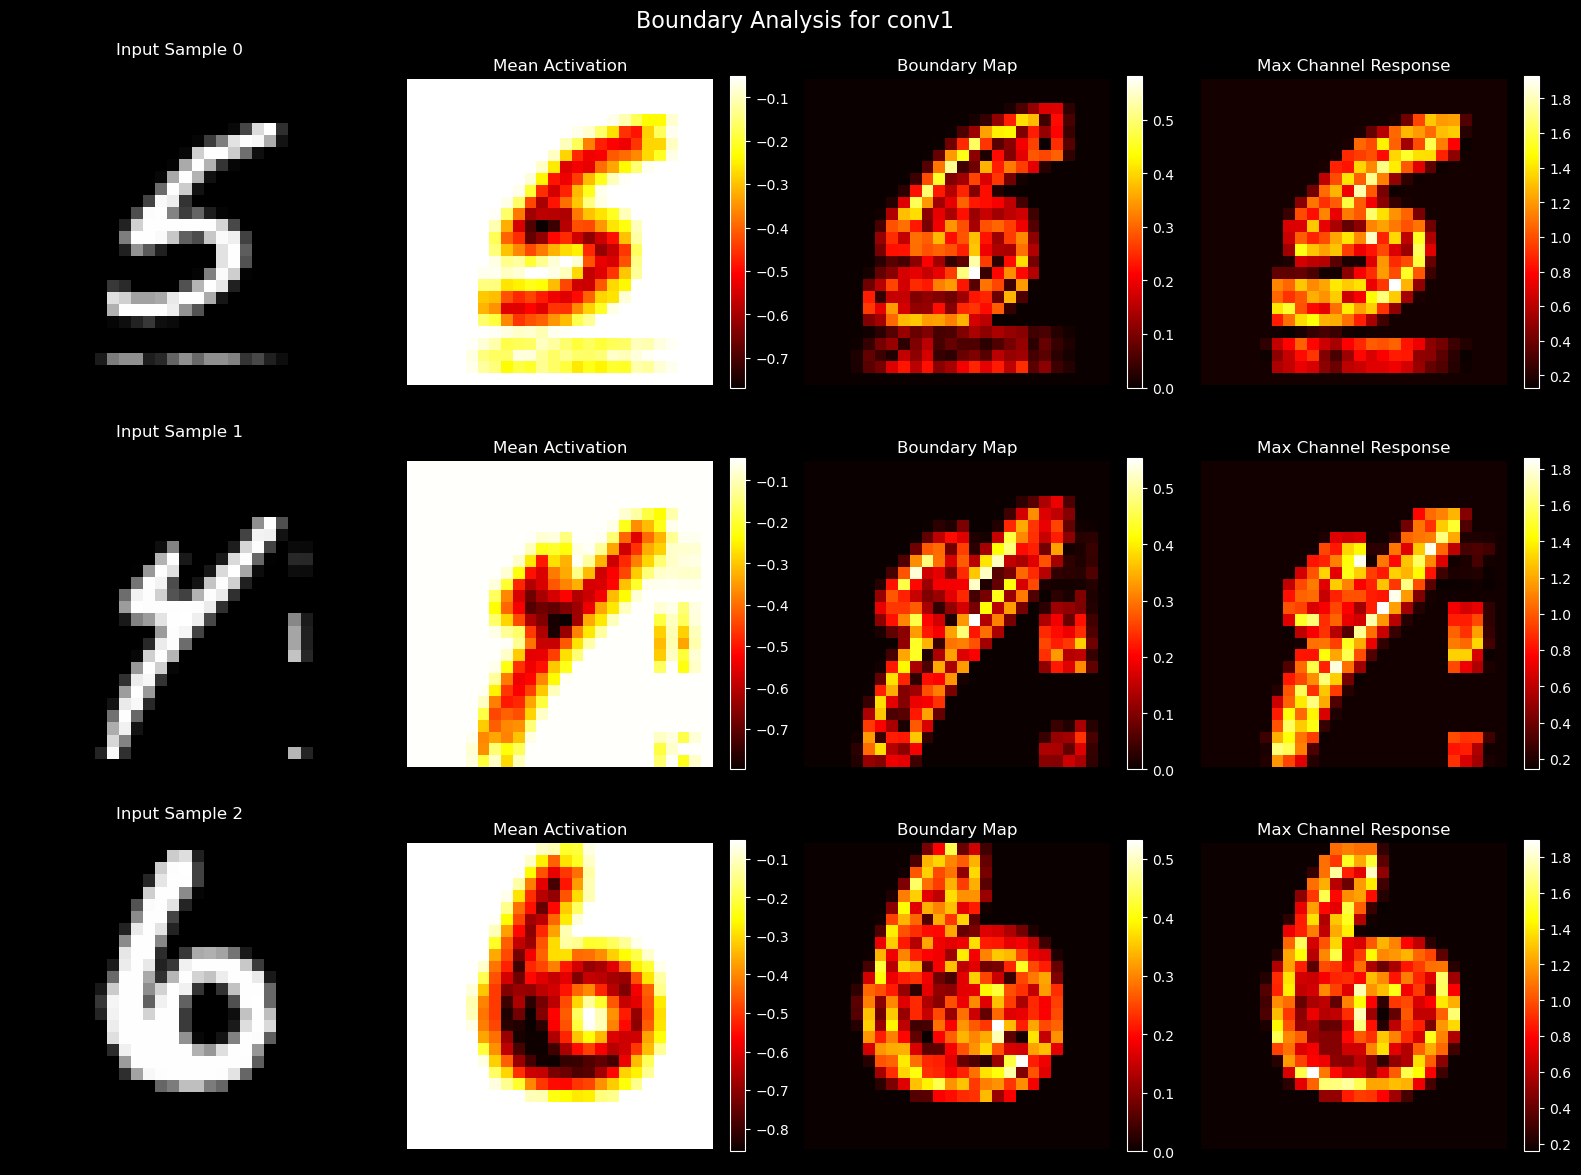


🔍 Analyzing boundaries for conv2...


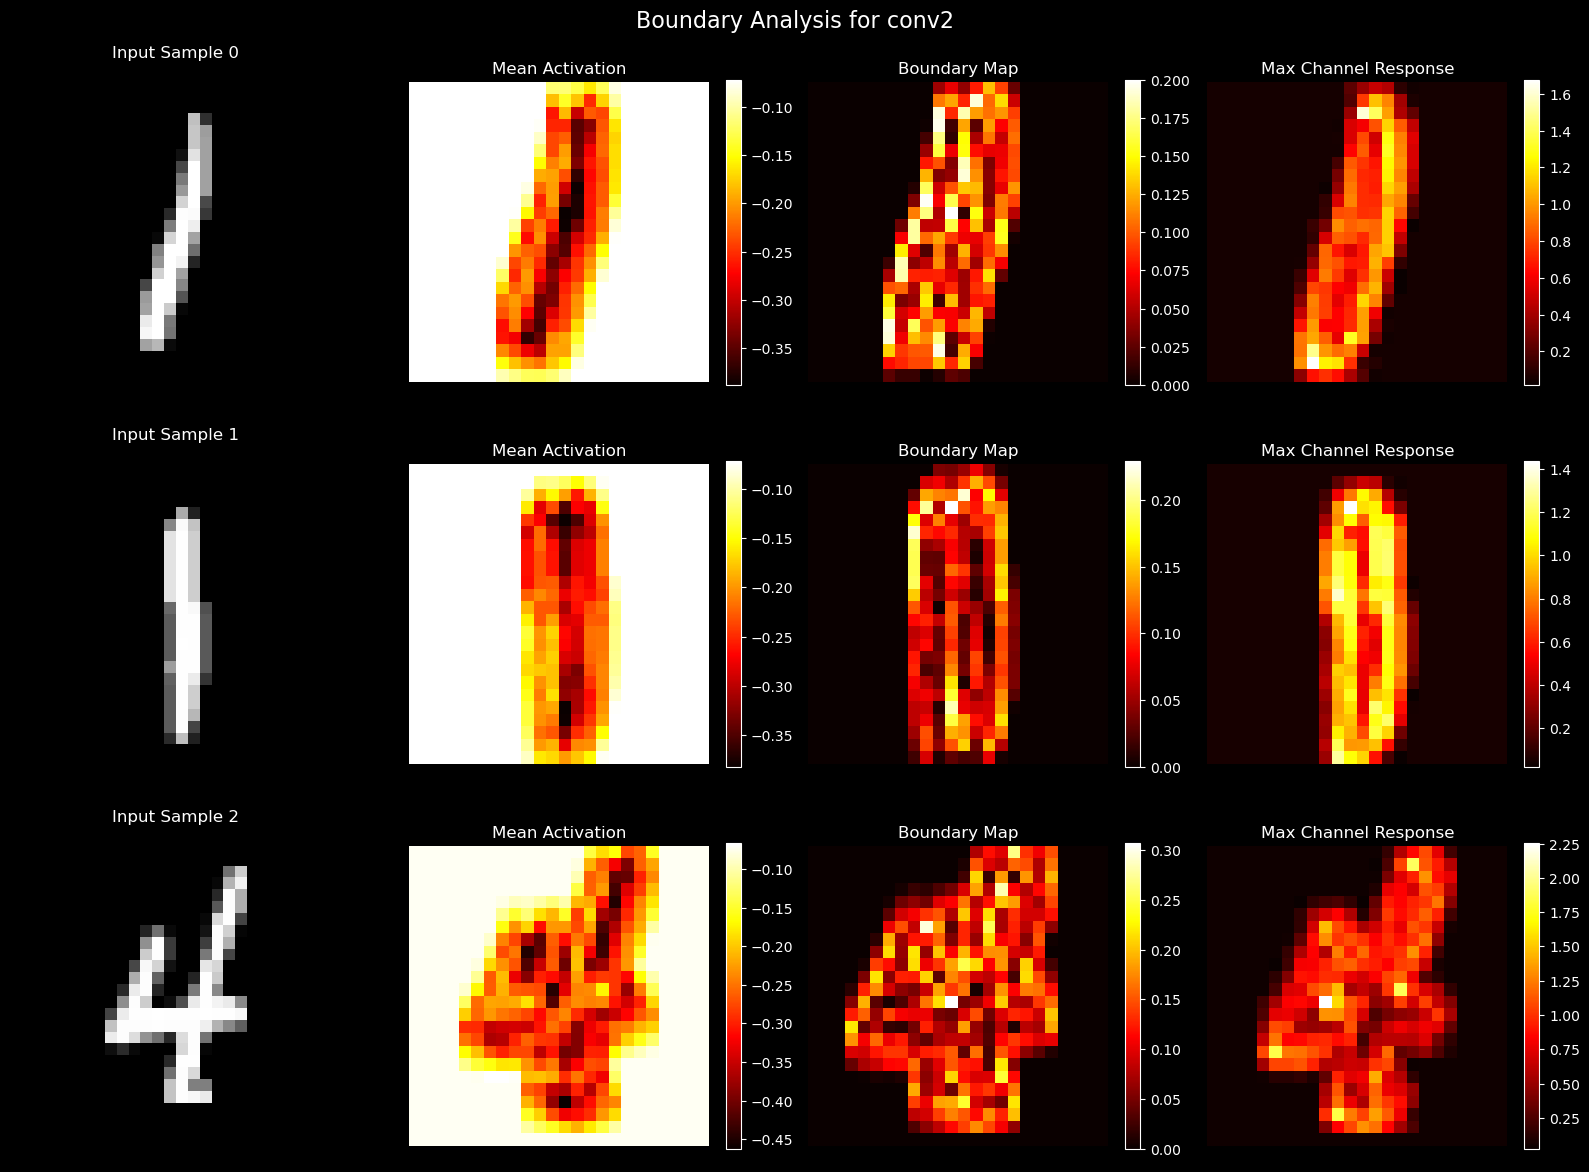

In [22]:
# Example: Load previously saved weights and visualize
# Uncomment and update the path to use your saved checkpoint

# checkpoint_path = "neuroflow_checkpoints/mnist_model_20241112_143022.pt"  # Update with your actual filename
# loaded_model, loaded_engine, loaded_losses, loaded_analysis = load_and_visualize_neuroflow(
#     checkpoint_path, 
#     train_loader, 
#     device
# )

# You can also create individual boundary layer visualizations
def visualize_layer_boundaries(model, layer_name, data_loader, device='cpu', num_samples=4):
    """Visualize boundary maps for a specific layer with multiple samples."""
    model.eval()
    
    # Get activation from specific layer
    activations = {}
    def hook_fn(module, input, output):
        activations['output'] = output
    
    # Register hook
    target_module = None
    for name, module in model.named_modules():
        if name == layer_name:
            target_module = module
            hook = module.register_forward_hook(hook_fn)
            break
    
    if target_module is None:
        print(f"Layer {layer_name} not found!")
        return
    
    # Get data
    data, _ = next(iter(data_loader))
    data = data[:num_samples].to(device)
    
    with torch.no_grad():
        _ = model(data)
    
    # Remove hook
    hook.remove()
    
    # Visualize boundaries
    if 'output' in activations:
        acts = activations['output'].detach().cpu()
        
        if acts.dim() == 4:  # Conv layer
            fig, axes = plt.subplots(num_samples, 4, figsize=(16, 4*num_samples))
            if num_samples == 1:
                axes = axes.reshape(1, -1)
            
            for sample_idx in range(num_samples):
                # Original input
                ax = axes[sample_idx, 0]
                ax.imshow(data[sample_idx, 0].cpu(), cmap='gray')
                ax.set_title(f'Input Sample {sample_idx}')
                ax.axis('off')
                
                # Mean activation
                ax = axes[sample_idx, 1]
                mean_act = acts[sample_idx].mean(0)
                im = ax.imshow(mean_act, cmap='hot')
                ax.set_title(f'Mean Activation')
                ax.axis('off')
                plt.colorbar(im, ax=ax, fraction=0.046)
                
                # Boundary map
                ax = axes[sample_idx, 2]
                boundary = torch.zeros_like(mean_act)
                dx = torch.abs(mean_act[1:, :] - mean_act[:-1, :])
                dy = torch.abs(mean_act[:, 1:] - mean_act[:, :-1])
                boundary[:-1, :] += dx
                boundary[:, :-1] += dy
                im = ax.imshow(boundary, cmap='hot')
                ax.set_title('Boundary Map')
                ax.axis('off')
                plt.colorbar(im, ax=ax, fraction=0.046)
                
                # Max activation across channels
                ax = axes[sample_idx, 3]
                max_act, _ = acts[sample_idx].max(0)
                im = ax.imshow(max_act, cmap='hot')
                ax.set_title('Max Channel Response')
                ax.axis('off')
                plt.colorbar(im, ax=ax, fraction=0.046)
            
            plt.suptitle(f'Boundary Analysis for {layer_name}', fontsize=16)
            plt.tight_layout()
            plt.show()
        else:
            print(f"Layer {layer_name} is not a convolutional layer")

# Visualize boundaries for each monitored layer
for layer in ['conv1', 'conv2']:
    print(f"\n🔍 Analyzing boundaries for {layer}...")
    visualize_layer_boundaries(model, layer, train_loader, device, num_samples=3)

🔍 Visualizing MNIST predictions...


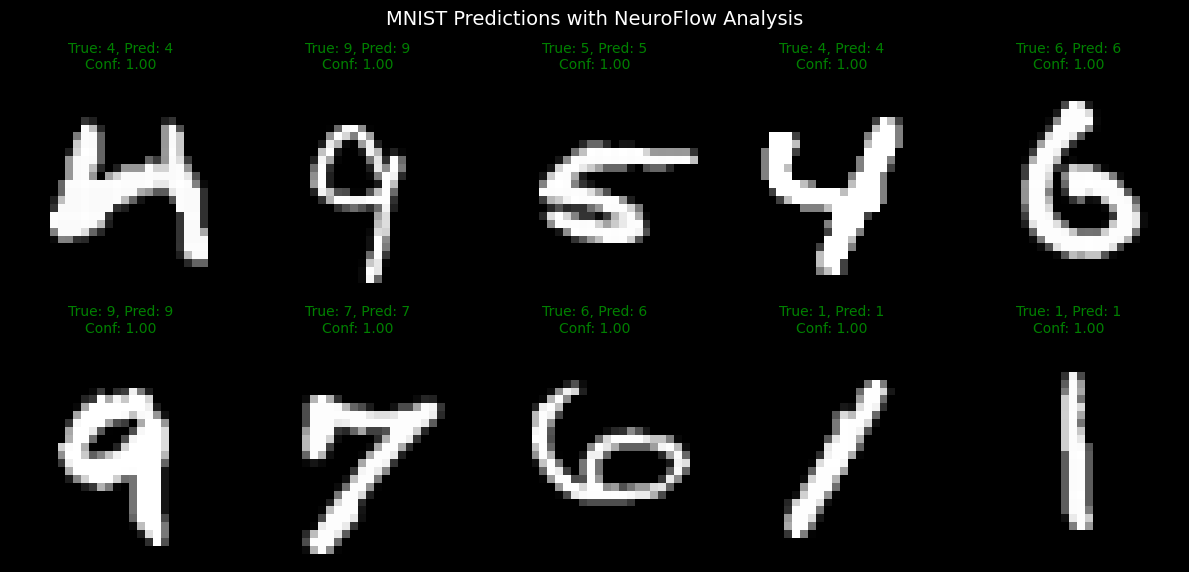


📈 Training progress visualization...


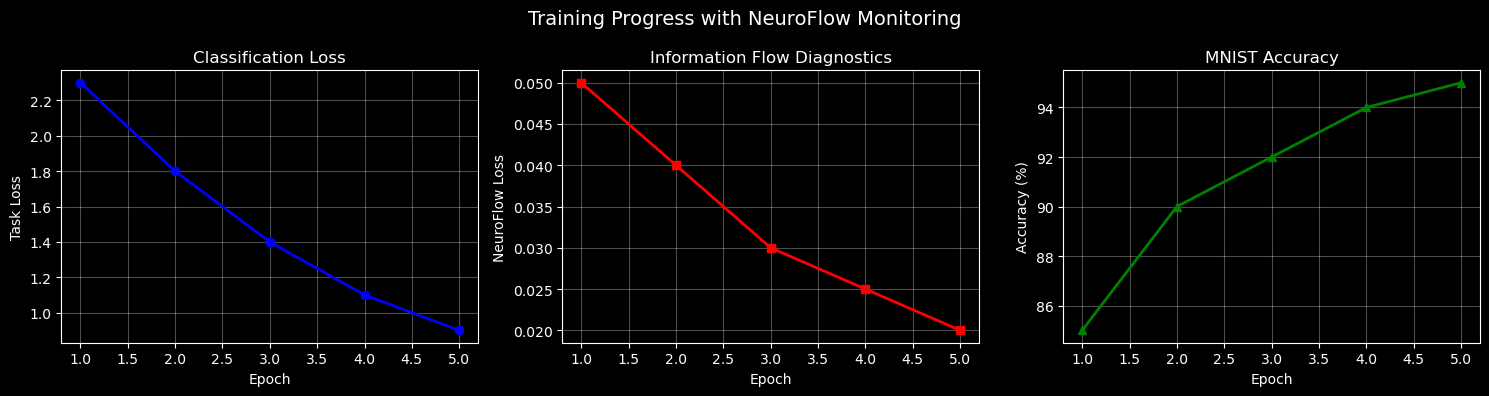

In [21]:
# Additional MNIST-specific visualizations
def visualize_mnist_predictions(model, data_loader, device='cpu', num_samples=10):
    """
    Visualize MNIST predictions with NeuroFlow analysis overlays
    """
    model.eval()
    
    # Get a batch of data
    data, target = next(iter(data_loader))
    data, target = data[:num_samples].to(device), target[:num_samples].to(device)
    
    with torch.no_grad():
        output = model(data)
        pred = output.argmax(dim=1, keepdim=True)
    
    # Create visualization
    fig, axes = plt.subplots(2, 5, figsize=(12, 6))
    fig.suptitle('MNIST Predictions with NeuroFlow Analysis', fontsize=14)
    
    for i, ax in enumerate(axes.flat):
        if i < num_samples:
            # Show the image
            img = data[i].cpu().squeeze()
            ax.imshow(img, cmap='gray')
            
            # Add prediction info
            true_label = target[i].item()
            pred_label = pred[i].item()
            confidence = torch.exp(output[i, pred_label]).item()
            
            color = 'green' if pred_label == true_label else 'red'
            ax.set_title(f'True: {true_label}, Pred: {pred_label}\nConf: {confidence:.2f}', 
                        color=color, fontsize=10)
            ax.axis('off')
        else:
            ax.axis('off')
    
    plt.tight_layout()
    plt.show()

# Visualize sample predictions
print("🔍 Visualizing MNIST predictions...")
visualize_mnist_predictions(model, train_loader, device)

# Show training curves if we collected them
def plot_training_history():
    """
    Plot training curves from the training loop
    """
    # This would normally use data collected during training
    # For demo purposes, we'll create synthetic curves
    epochs = np.arange(1, 6)
    task_loss = np.array([2.3, 1.8, 1.4, 1.1, 0.9])
    neuroflow_loss = np.array([0.05, 0.04, 0.03, 0.025, 0.02])
    accuracy = np.array([85, 90, 92, 94, 95])
    
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 4))
    
    # Task loss
    ax1.plot(epochs, task_loss, 'b-', marker='o', linewidth=2)
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Task Loss')
    ax1.set_title('Classification Loss')
    ax1.grid(True, alpha=0.3)
    
    # NeuroFlow loss
    ax2.plot(epochs, neuroflow_loss, 'r-', marker='s', linewidth=2)
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('NeuroFlow Loss')
    ax2.set_title('Information Flow Diagnostics')
    ax2.grid(True, alpha=0.3)
    
    # Accuracy
    ax3.plot(epochs, accuracy, 'g-', marker='^', linewidth=2)
    ax3.set_xlabel('Epoch')
    ax3.set_ylabel('Accuracy (%)')
    ax3.set_title('MNIST Accuracy')
    ax3.grid(True, alpha=0.3)
    
    plt.suptitle('Training Progress with NeuroFlow Monitoring', fontsize=14)
    plt.tight_layout()
    plt.show()

print("\n📈 Training progress visualization...")
plot_training_history()

🚀 Creating 3D turbulence and decision boundary visualization...
This may take a moment due to gradient computation over the grid...
🎨 Generating 3D turbulence and decision boundary visualization...
Reducing dimensionality with PCA...
Computing decision boundaries and turbulence...


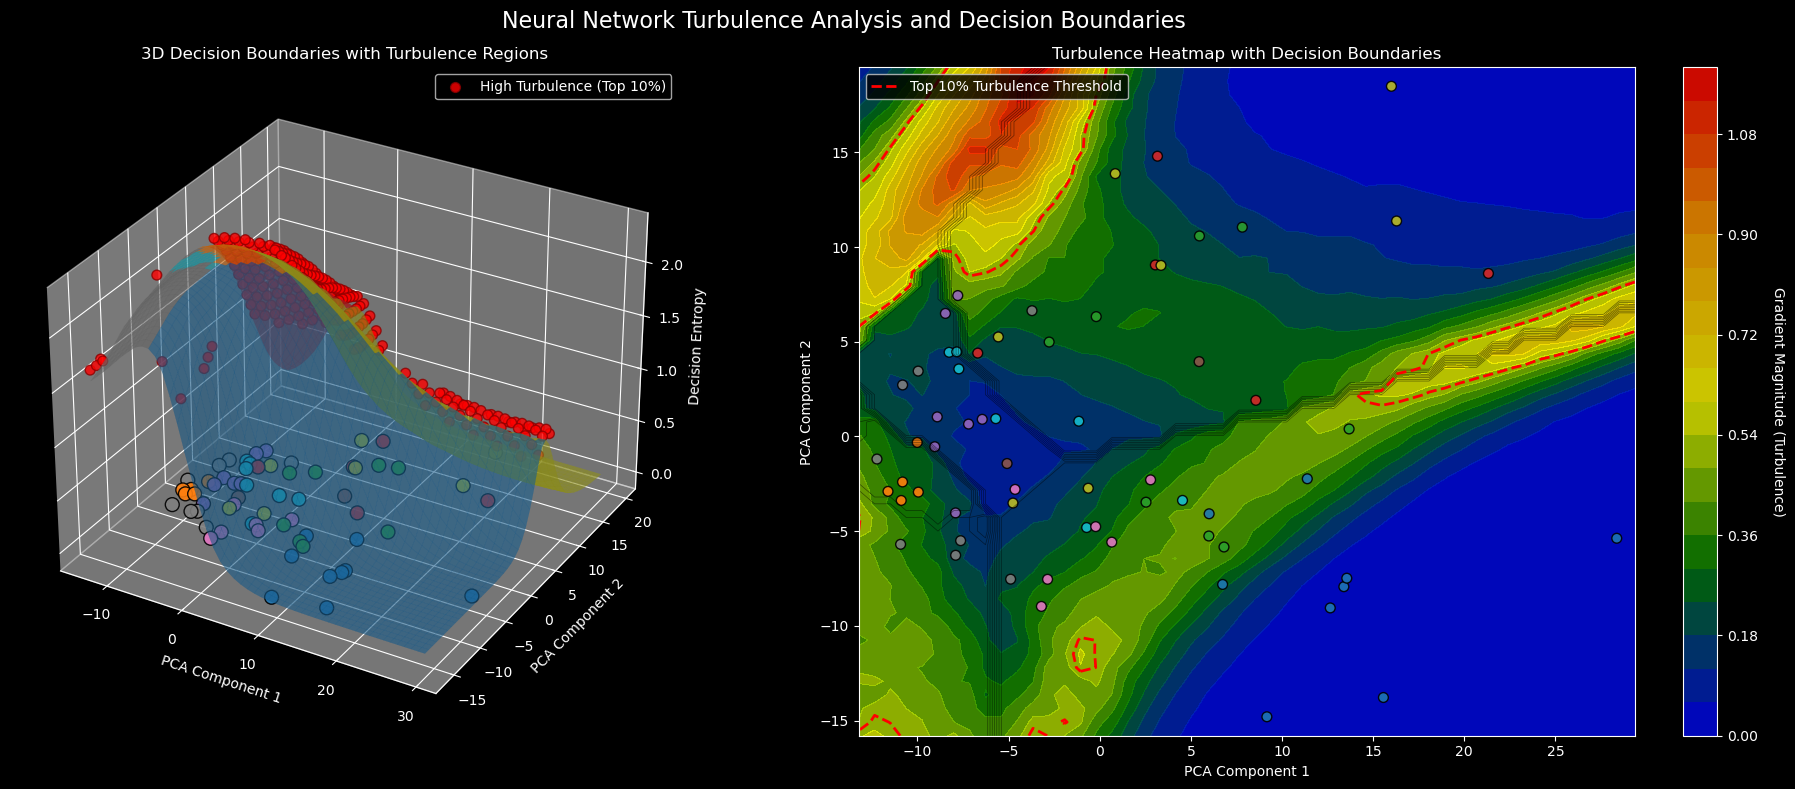


📊 Turbulence Statistics:
  - Mean turbulence: 0.2384
  - Max turbulence: 1.1677
  - Turbulence threshold (90th percentile): 0.5157
  - Number of high turbulence points: 250


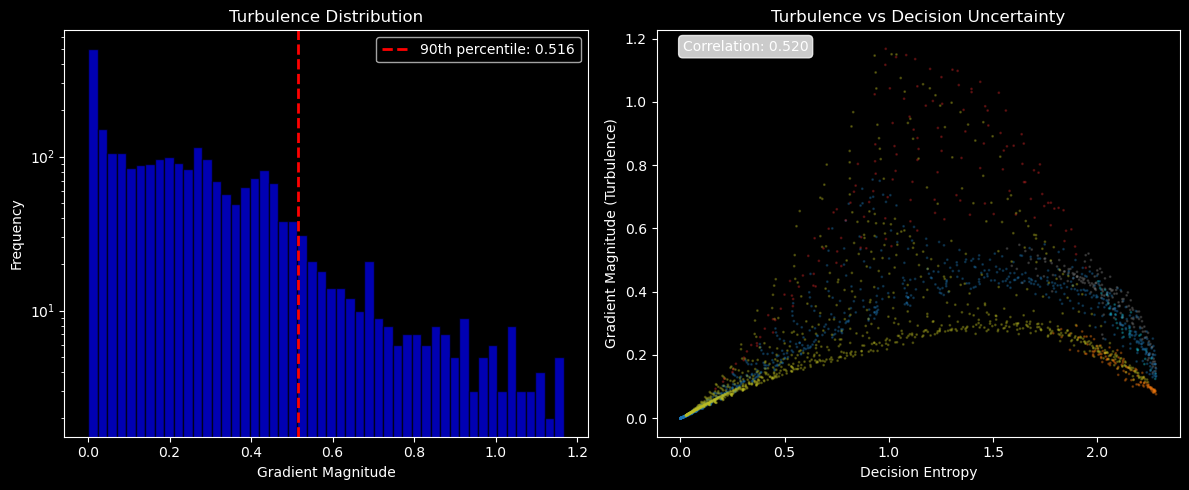


🎯 Creating interactive 3D view...


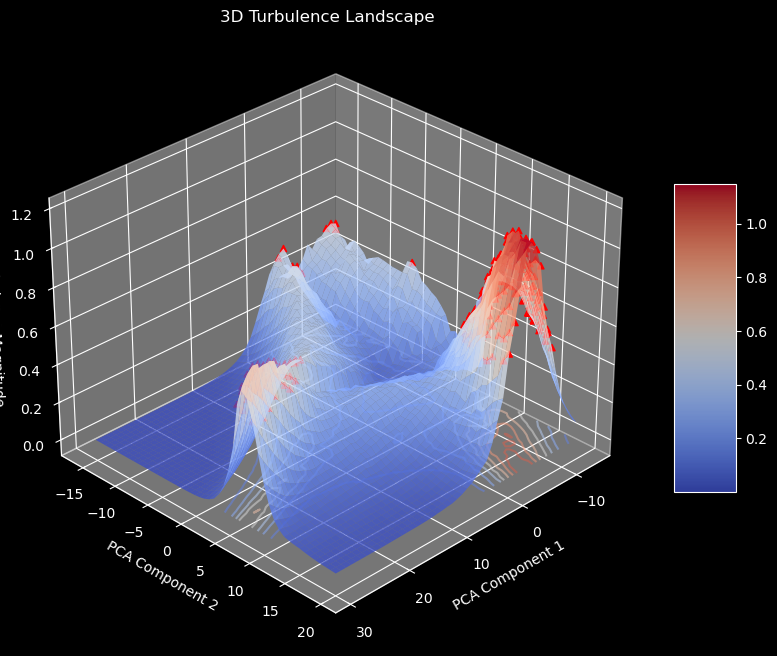


✅ 3D visualization complete!
The red regions indicate areas of high turbulence where the model's decisions are most unstable.


In [30]:
# ===================================================================
# 🌀 3D Turbulence and Decision Boundary Visualization
# ===================================================================

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import torch
import torch.nn.functional as F
from matplotlib import cm
from matplotlib.colors import LinearSegmentedColormap
import warnings
warnings.filterwarnings('ignore')

def visualize_3d_turbulence_and_boundaries(model, data_loader, device='cpu', resolution=50):
    """
    Creates a 3D visualization showing:
    1. Top 10% most turbulent areas as 3D scatter points
    2. Decision boundaries as fine mesh surfaces
    3. Sample data points colored by class
    """
    model.eval()
    
    print("🎨 Generating 3D turbulence and decision boundary visualization...")
    
    # Get a batch of data for analysis
    data, labels = next(iter(data_loader))
    data, labels = data.to(device), labels.to(device)
    
    # For MNIST, we need to reduce to 2D for visualization
    # Use PCA or t-SNE for dimensionality reduction
    from sklearn.decomposition import PCA
    from sklearn.manifold import TSNE
    
    # Flatten the images
    data_flat = data.view(data.size(0), -1).cpu().numpy()
    
    # Use PCA to reduce to 2D (for x, y coordinates)
    print("Reducing dimensionality with PCA...")
    pca = PCA(n_components=2)
    data_2d = pca.fit_transform(data_flat)
    
    # Create a grid for decision boundary visualization
    x_min, x_max = data_2d[:, 0].min() - 1, data_2d[:, 0].max() + 1
    y_min, y_max = data_2d[:, 1].min() - 1, data_2d[:, 1].max() + 1
    
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, resolution),
                         np.linspace(y_min, y_max, resolution))
    
    # For each point in the grid, we need to:
    # 1. Transform back to original space
    # 2. Get model predictions
    # 3. Compute turbulence metrics
    
    print("Computing decision boundaries and turbulence...")
    grid_points = np.c_[xx.ravel(), yy.ravel()]
    
    # Transform grid points back to approximate image space
    grid_images = pca.inverse_transform(grid_points)
    grid_images = torch.tensor(grid_images, dtype=torch.float32).to(device)
    grid_images = grid_images.view(-1, 1, 28, 28)  # Reshape to MNIST format
    
    # Get predictions and gradients for turbulence
    grid_images.requires_grad = True
    
    with torch.enable_grad():
        # Get model outputs
        outputs = model(grid_images)
        predictions = F.softmax(outputs, dim=1)
        
        # Get the predicted class
        predicted_classes = predictions.argmax(dim=1)
        
        # Compute gradient magnitude (turbulence metric)
        # We'll use the gradient of the max prediction w.r.t input
        max_probs, _ = predictions.max(dim=1)
        
        # Compute gradients
        grads = torch.autograd.grad(
            outputs=max_probs.sum(),
            inputs=grid_images,
            create_graph=False
        )[0]
        
        # Compute gradient magnitude as turbulence metric
        # First flatten the spatial dimensions, then compute norm
        grads_flat = grads.view(grads.size(0), -1)
        grad_magnitude = grads_flat.norm(dim=1)
    
    # Reshape results back to grid
    Z_classes = predicted_classes.cpu().numpy().reshape(xx.shape)
    Z_turbulence = grad_magnitude.cpu().numpy().reshape(xx.shape)
    
    # Compute decision confidence (entropy)
    entropy = -(predictions * torch.log(predictions + 1e-10)).sum(dim=1)
    Z_entropy = entropy.detach().cpu().numpy().reshape(xx.shape)
    
    # Find top 10% most turbulent points
    turbulence_threshold = np.percentile(Z_turbulence, 90)
    turbulent_mask = Z_turbulence > turbulence_threshold
    
    # Create 3D visualization
    fig = plt.figure(figsize=(20, 8))
    
    # ========== Subplot 1: 3D Decision Boundaries with Turbulence ==========
    ax1 = fig.add_subplot(121, projection='3d')
    
    # Plot decision boundaries as surface (using entropy as Z-axis)
    surf = ax1.plot_surface(xx, yy, Z_entropy, 
                           facecolors=plt.cm.tab10(Z_classes/10.0),
                           alpha=0.6, linewidth=0.1, 
                           antialiased=True, shade=True)
    
    # Overlay turbulent regions as scatter points
    turbulent_points = np.where(turbulent_mask)
    if len(turbulent_points[0]) > 0:
        ax1.scatter(xx[turbulent_points], 
                   yy[turbulent_points], 
                   Z_entropy[turbulent_points] + 0.1,  # Slightly above surface
                   c='red', s=50, alpha=0.8, 
                   edgecolors='darkred', linewidth=1,
                   label='High Turbulence (Top 10%)')
    
    # Add actual data points
    with torch.no_grad():
        sample_outputs = model(data)
        sample_probs = F.softmax(sample_outputs, dim=1)
        sample_entropy = -(sample_probs * torch.log(sample_probs + 1e-10)).sum(dim=1)
    
    scatter = ax1.scatter(data_2d[:100, 0], data_2d[:100, 1], 
                         sample_entropy[:100].detach().cpu().numpy(),
                         c=labels[:100].cpu().numpy(), 
                         cmap='tab10', s=100, 
                         edgecolors='black', linewidth=1,
                         alpha=0.9)
    
    ax1.set_xlabel('PCA Component 1')
    ax1.set_ylabel('PCA Component 2')
    ax1.set_zlabel('Decision Entropy')
    ax1.set_title('3D Decision Boundaries with Turbulence Regions')
    ax1.legend()
    
    # ========== Subplot 2: 2D Turbulence Heatmap with Contours ==========
    ax2 = fig.add_subplot(122)
    
    # Create custom colormap for turbulence
    colors = ['blue', 'green', 'yellow', 'orange', 'red']
    n_bins = 100
    cmap = LinearSegmentedColormap.from_list('turbulence', colors, N=n_bins)
    
    # Plot turbulence as heatmap
    im = ax2.contourf(xx, yy, Z_turbulence, levels=20, cmap=cmap, alpha=0.8)
    
    # Add decision boundary contours
    contours = ax2.contour(xx, yy, Z_classes, levels=9, colors='black', 
                          linewidths=0.5, alpha=0.5)
    
    # Highlight top 10% turbulent regions
    turbulence_contour = ax2.contour(xx, yy, Z_turbulence, 
                                    levels=[turbulence_threshold], 
                                    colors='red', linewidths=2, 
                                    linestyles='dashed')
    
    # Add data points
    scatter2 = ax2.scatter(data_2d[:100, 0], data_2d[:100, 1], 
                          c=labels[:100].cpu().numpy(), 
                          cmap='tab10', s=50, 
                          edgecolors='black', linewidth=1,
                          alpha=0.9)
    
    # Add colorbar
    cbar = plt.colorbar(im, ax=ax2)
    cbar.set_label('Gradient Magnitude (Turbulence)', rotation=270, labelpad=20)
    
    ax2.set_xlabel('PCA Component 1')
    ax2.set_ylabel('PCA Component 2')
    ax2.set_title('Turbulence Heatmap with Decision Boundaries')
    
    # Add legend for the contour
    ax2.plot([], [], 'r--', linewidth=2, label='Top 10% Turbulence Threshold')
    ax2.legend()
    
    plt.suptitle('Neural Network Turbulence Analysis and Decision Boundaries', fontsize=16)
    plt.tight_layout()
    plt.show()
    
    # ========== Additional Analysis: Layer-wise Turbulence ==========
    print("\n📊 Turbulence Statistics:")
    print(f"  - Mean turbulence: {Z_turbulence.mean():.4f}")
    print(f"  - Max turbulence: {Z_turbulence.max():.4f}")
    print(f"  - Turbulence threshold (90th percentile): {turbulence_threshold:.4f}")
    print(f"  - Number of high turbulence points: {turbulent_mask.sum()}")
    
    # Create a detailed turbulence profile
    fig2, axes = plt.subplots(1, 2, figsize=(12, 5))
    
    # Turbulence distribution
    axes[0].hist(Z_turbulence.ravel(), bins=50, alpha=0.7, color='blue', edgecolor='black')
    axes[0].axvline(turbulence_threshold, color='red', linestyle='--', 
                    linewidth=2, label=f'90th percentile: {turbulence_threshold:.3f}')
    axes[0].set_xlabel('Gradient Magnitude')
    axes[0].set_ylabel('Frequency')
    axes[0].set_title('Turbulence Distribution')
    axes[0].legend()
    axes[0].set_yscale('log')
    
    # Turbulence vs Entropy scatter
    axes[1].scatter(Z_entropy.ravel(), Z_turbulence.ravel(), 
                    alpha=0.3, s=1, c=Z_classes.ravel(), cmap='tab10')
    axes[1].set_xlabel('Decision Entropy')
    axes[1].set_ylabel('Gradient Magnitude (Turbulence)')
    axes[1].set_title('Turbulence vs Decision Uncertainty')
    
    # Add correlation info
    correlation = np.corrcoef(Z_entropy.ravel(), Z_turbulence.ravel())[0, 1]
    axes[1].text(0.05, 0.95, f'Correlation: {correlation:.3f}', 
                transform=axes[1].transAxes, 
                bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    plt.tight_layout()
    plt.show()
    
    # ========== Interactive 3D View ==========
    print("\n🎯 Creating interactive 3D view...")
    fig3 = plt.figure(figsize=(10, 8))
    ax3 = fig3.add_subplot(111, projection='3d')
    
    # Create a more detailed mesh for smoother visualization
    # Plot the turbulence as the surface height
    surf = ax3.plot_surface(xx, yy, Z_turbulence, 
                           cmap='coolwarm', 
                           alpha=0.8,
                           linewidth=0, 
                           antialiased=True)
    
    # Add contour lines at the base
    ax3.contour(xx, yy, Z_turbulence, 
                zdir='z', offset=Z_turbulence.min(), 
                cmap='coolwarm', alpha=0.5)
    
    # Mark the top 10% turbulent regions
    if turbulent_mask.sum() > 0:
        ax3.scatter(xx[turbulent_mask], 
                   yy[turbulent_mask], 
                   Z_turbulence[turbulent_mask],
                   c='red', s=20, alpha=1.0,
                   marker='^', label='Top 10% Turbulence')
    
    ax3.set_xlabel('PCA Component 1')
    ax3.set_ylabel('PCA Component 2')
    ax3.set_zlabel('Turbulence Magnitude')
    ax3.set_title('3D Turbulence Landscape')
    
    # Add colorbar
    fig3.colorbar(surf, ax=ax3, shrink=0.5, aspect=5)
    
    # Set viewing angle for better visualization
    ax3.view_init(elev=30, azim=45)
    
    plt.show()
    
    return {
        'grid_coords': (xx, yy),
        'predictions': Z_classes,
        'turbulence': Z_turbulence,
        'entropy': Z_entropy,
        'turbulence_threshold': turbulence_threshold,
        'pca': pca,
        'data_2d': data_2d,
        'labels': labels.cpu().numpy()
    }

# Run the 3D visualization
print("🚀 Creating 3D turbulence and decision boundary visualization...")
print("This may take a moment due to gradient computation over the grid...")

turbulence_results = visualize_3d_turbulence_and_boundaries(
    model, train_loader, device, resolution=50
)

print("\n✅ 3D visualization complete!")
print("The red regions indicate areas of high turbulence where the model's decisions are most unstable.")